# Taller 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [2]:
shapefile_path = "MGN2024_MPIO_POLITICO/MGN_ADM_MPIO_GRAFICO.shp"
map=gpd.read_file(shapefile_path)
map.head()

,dpto_ccdgo,mpio_ccdgo,mpio_cdpmp,dpto_cnmbr,mpio_cnmbr,mpio_crslc,mpio_tipo,mpio_narea,mpio_nano,shape_Leng,shape_Area,geometry
0,05,001,05001,ANTIOQUIA,MEDELLÍN,1965,MUNICIPIO,374.834005,2024,1.035380,0.030608,"POLYGON ((-75.66974 6.3736, -75.66965 6.3736, ..."
1,05,002,05002,ANTIOQUIA,ABEJORRAL,1814,MUNICIPIO,507.141095,2024,1.158504,0.041384,"POLYGON ((-75.46938 5.94575, -75.46897 5.94571..."
2,05,004,05004,ANTIOQUIA,ABRIAQUÍ,1912,MUNICIPIO,296.894050,2024,0.812183,0.024248,"POLYGON ((-76.08351 6.7505, -76.08325 6.75048,..."
3,05,021,05021,ANTIOQUIA,ALEJANDRÍA,Decreto departamental 304 de 1907,MUNICIPIO,128.932153,2024,0.705200,0.010535,"POLYGON ((-75.0332 6.41586, -75.03313 6.41585,..."
4,05,030,05030,ANTIOQUIA,AMAGÁ,1912,MUNICIPIO,84.132477,2024,0.445533,0.006867,"POLYGON ((-75.67587 6.08561, -75.6754 6.08491,..."


In [3]:
map['dpto_ccdgo'] = map["dpto_ccdgo"].astype(int)

In [4]:
# Carga TIC y diseño muestral
tic = pd.read_csv("Tecnologias de informacion y comunicacion.CSV",sep=";")
diseno = pd.read_csv("Variables diseno muestral.CSV",sep=";")
diseno.head()



,DIRECTORIO,SECUENCIA_P,ORDEN,MPIO,SEGMENTO,ESTRATO2020,F2,F_ETAPA1,FRES,FEX_C,BLOQUE
0,8219789,1,1,8001,10143,898,1.0,478.63749,478.63749,651.298866,A00008
1,8219789,1,2,8001,10143,898,1.0,478.63749,478.63749,651.298866,A00008
2,8219789,1,3,8001,10143,898,1.0,478.63749,478.63749,651.298866,A00008
3,8219789,1,4,8001,10143,898,1.0,478.63749,478.63749,651.298866,A00008
4,8219789,1,5,8001,10143,898,1.0,478.63749,478.63749,651.298866,A00008


In [5]:
tic.head()

,DIRECTORIO,SECUENCIA_ENCUESTA,SECUENCIA_P,ORDEN,FEX_C,P1910,P1911,P1912,P1084,P1710,...,P1080S4,P1080S5,P1080S6,P804,P805,P805S1,P805S2,P805S3,P805S4,P805S5
0,8219789,1,1,1,651.298866,5,5,5,1,NaN,...,1.0,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN
1,8219789,2,1,2,651.298866,5,5,5,1,NaN,...,1.0,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN
2,8219789,3,1,3,651.298866,5,2,5,1,NaN,...,1.0,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN
3,8219789,4,1,4,651.298866,5,5,2,2,NaN,...,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN
4,8219789,5,1,5,651.298866,5,5,5,1,NaN,...,1.0,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Selecciona solo las columnas necesarias
diseno = diseno[["DIRECTORIO", "MPIO"]]

# Une por DIRECTORIO
df = tic.merge(diseno, on="DIRECTORIO", how="left")

df["DPTO"] = df["MPIO"].astype(str).str[:2]
df["DPTO"] = df["DPTO"].astype(str).str.zfill(2)
map["dpto_ccdgo"] = map["dpto_ccdgo"].astype(str).str.zfill(2)
resumen = (
    df.groupby("DPTO")["P1084"]
      .apply(lambda x: (x == 1).mean() * 100)  # porcentaje
      .reset_index(name="porc_internet")
)

In [7]:
df = df.copy()
# Crear banderas binarias
df["convencional"] = ((df["P1082"] == 1) & (df["P1082S1"] == 1)).astype(int)
df["inteligente"]  = ((df["P1082"] == 1) & (df["P1082S2"] == 1)).astype(int)

# Si P1082 == 2 (no tiene celular) → se asegura que todo sea 0
df.loc[df["P1082"] == 2, ["convencional", "inteligente"]] = 0

# --- Resumir por departamento ---
resumen_cel = (
    df.groupby("DPTO")[["convencional", "inteligente"]]
      .mean()
      .reset_index()
)

# Pasar a porcentajes
resumen_cel[["convencional", "inteligente"]] *= 100

In [8]:
departamentos = map.dissolve(by="dpto_ccdgo", as_index=False)

In [9]:
gdf = departamentos.merge(resumen, left_on="dpto_ccdgo", right_on="DPTO", how="left")


<Axes: >

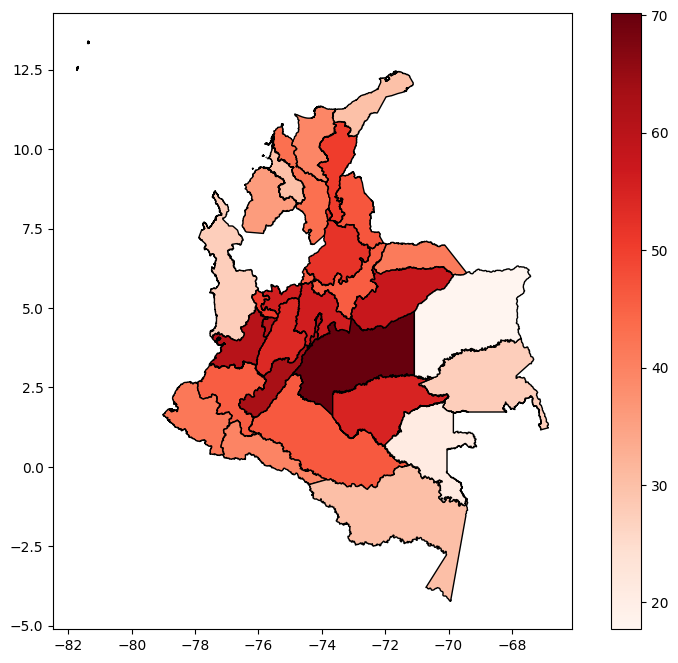

In [10]:
gdf.plot(
    column="porc_internet",
    cmap="Reds",
    legend=True,
    edgecolor="black",
    figsize=(10, 8)
)


In [11]:
gdf = gdf.merge(resumen_cel, left_on="dpto_ccdgo", right_on="DPTO", how="left")

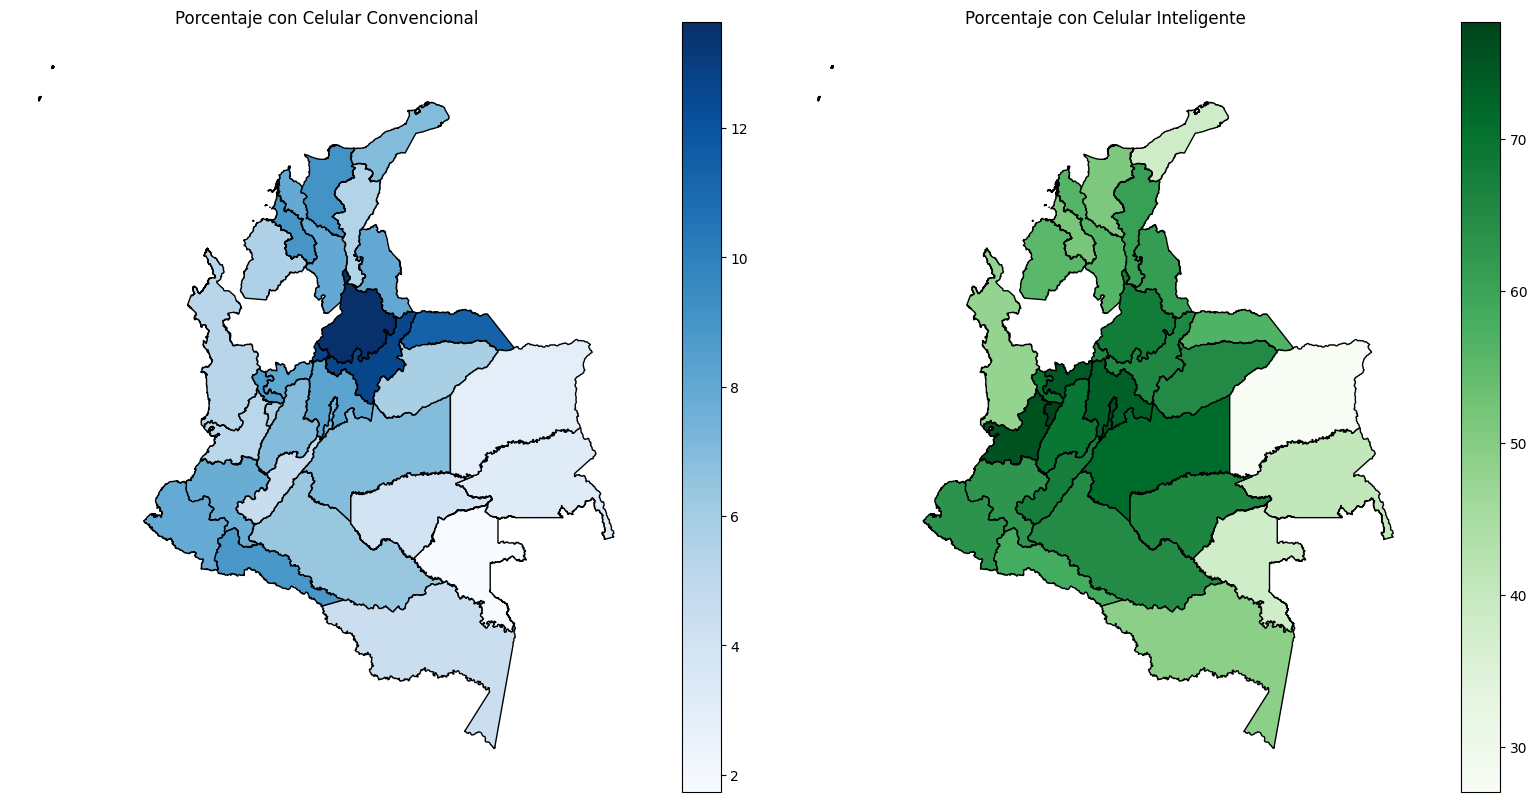

In [12]:
# Crear figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Mapa 1: Celular convencional
gdf.plot(
    column="convencional",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    ax=axes[0]
)
axes[0].set_title("Porcentaje con Celular Convencional")

# Mapa 2: Celular inteligente
gdf.plot(
    column="inteligente",
    cmap="Greens",
    legend=True,
    edgecolor="black",
    ax=axes[1]
)
axes[1].set_title("Porcentaje con Celular Inteligente")

# Quitar ejes
for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()